### Downlaod necessary libraries. 

In [9]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
# import graphviz
import os
# import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
import warnings

### Set display options.

In [10]:
pd.set_option("display.max.columns", 50)
warnings.filterwarnings("ignore")
# %matplotlib inline 

### Import data (csv file, dowloaded from IBM Base Samples).

In [11]:
df = pd.read_csv(r"C:\Users\OK\Documents\Self\I know Python\Telco_customer_churn.csv")
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


### Explore and clean the data.

In [12]:
# Explore the data as imported. The data set has 7043 observations across 33 variables. The df index is rangeindex. 
print(df.index)
print(df.size)
print(df.shape)
df.dtypes

RangeIndex(start=0, stop=7043, step=1)
232419
(7043, 33)


CustomerID            object
Count                  int64
Country               object
State                 object
City                  object
Zip Code               int64
Lat Long              object
Latitude             float64
Longitude            float64
Gender                object
Senior Citizen        object
Partner               object
Dependents            object
Tenure Months          int64
Phone Service         object
Multiple Lines        object
Internet Service      object
Online Security       object
Online Backup         object
Device Protection     object
Tech Support          object
Streaming TV          object
Streaming Movies      object
Contract              object
Paperless Billing     object
Payment Method        object
Monthly Charges      float64
Total Charges         object
Churn Label           object
Churn Value            int64
Churn Score            int64
CLTV                   int64
Churn Reason          object
dtype: object

### Finding and Managing Missing Data (consistent with the XGBoost algorithm's requirements).

In [13]:
# First check for missing data, using a for loop.
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print("{} - {}%".format(col, round(pct_missing*100)))

CustomerID - 0%
Count - 0%
Country - 0%
State - 0%
City - 0%
Zip Code - 0%
Lat Long - 0%
Latitude - 0%
Longitude - 0%
Gender - 0%
Senior Citizen - 0%
Partner - 0%
Dependents - 0%
Tenure Months - 0%
Phone Service - 0%
Multiple Lines - 0%
Internet Service - 0%
Online Security - 0%
Online Backup - 0%
Device Protection - 0%
Tech Support - 0%
Streaming TV - 0%
Streaming Movies - 0%
Contract - 0%
Paperless Billing - 0%
Payment Method - 0%
Monthly Charges - 0%
Total Charges - 0%
Churn Label - 0%
Churn Value - 0%
Churn Score - 0%
CLTV - 0%
Churn Reason - 73%


In [14]:
# Another check for NA. 
df.isna().any() # No NA

CustomerID           False
Count                False
Country              False
State                False
City                 False
Zip Code             False
Lat Long             False
Latitude             False
Longitude            False
Gender               False
Senior Citizen       False
Partner              False
Dependents           False
Tenure Months        False
Phone Service        False
Multiple Lines       False
Internet Service     False
Online Security      False
Online Backup        False
Device Protection    False
Tech Support         False
Streaming TV         False
Streaming Movies     False
Contract             False
Paperless Billing    False
Payment Method       False
Monthly Charges      False
Total Charges        False
Churn Label          False
Churn Value          False
Churn Score          False
CLTV                 False
Churn Reason          True
dtype: bool

#### The missing data in the column "Churn Reason" can be disregarded because this column will be removed for the analysis.
However, as an incidental discovery, a 73% missing data rate should be reported back to the responsible department
for process improvement. 

In [15]:
# Check the Total Charges variable which shows up as "object" but must be a float. 
df["Total Charges"].unique()[0:10]

array(['108.15', '151.65', '820.5', '3046.05', '5036.3', '528.35',
       '39.65', '20.15', '4749.15', '30.2'], dtype=object)

In [16]:
# Convert "Total Charges" to float. 
# df["Total_Charges"] = df["Total Charges"].asfloat() # Did not work, got Key Error. 

In [17]:
# Check if there is missing data as blanks for the "Total Charges" variable. 
len(df.loc[df["Total Charges"] == " "])

11

In [18]:
# Explore the 11 missing observations in the context of the data set. 
df.loc[df["Total Charges"] == " "]

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
2234,4472-LVYGI,1,United States,California,San Bernardino,92408,"34.084909, -117.258107",34.084909,-117.258107,Female,No,Yes,No,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No,0,36,2578,NaN
2438,3115-CZMZD,1,United States,California,Independence,93526,"36.869584, -118.189241",36.869584,-118.189241,Male,No,No,No,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No,0,68,5504,NaN
2568,5709-LVOEQ,1,United States,California,San Mateo,94401,"37.590421, -122.306467",37.590421,-122.306467,Female,No,Yes,No,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No,0,45,2048,NaN
2667,4367-NUYAO,1,United States,California,Cupertino,95014,"37.306612, -122.080621",37.306612,-122.080621,Male,No,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No,0,48,4950,NaN
2856,1371-DWPAZ,1,United States,California,Redcrest,95569,"40.363446, -123.835041",40.363446,-123.835041,Female,No,Yes,No,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No,0,30,4740,NaN
4331,7644-OMVMY,1,United States,California,Los Angeles,90029,"34.089953, -118.294824",34.089953,-118.294824,Male,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No,0,53,2019,NaN
4687,3213-VVOLG,1,United States,California,Sun City,92585,"33.739412, -117.173334",33.739412,-117.173334,Male,No,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No,0,49,2299,NaN
5104,2520-SGTTA,1,United States,California,Ben Lomond,95005,"37.078873, -122.090386",37.078873,-122.090386,Female,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No,0,27,3763,NaN
5719,2923-ARZLG,1,United States,California,La Verne,91750,"34.144703, -117.770299",34.144703,-117.770299,Male,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No,0,69,4890,NaN
6772,4075-WKNIU,1,United States,California,Bell,90201,"33.970343, -118.171368",33.970343,-118.171368,Female,No,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No,0,44,2342,NaN


#### The 11 missing Total Charges belong to the customers with zero Tenure Months and who are still with the 
#### company indicating that these are new customers. It is reasonable to assgn $0 to their Total Charges. 

In [19]:
# Assign zero to the new customers' Total Charges. 
df.loc[(df["Total Charges"] == " "), "Total Charges"] = 0
df.loc[df["Tenure Months"] == 0]

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
2234,4472-LVYGI,1,United States,California,San Bernardino,92408,"34.084909, -117.258107",34.084909,-117.258107,Female,No,Yes,No,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,0,No,0,36,2578,NaN
2438,3115-CZMZD,1,United States,California,Independence,93526,"36.869584, -118.189241",36.869584,-118.189241,Male,No,No,No,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,0,No,0,68,5504,NaN
2568,5709-LVOEQ,1,United States,California,San Mateo,94401,"37.590421, -122.306467",37.590421,-122.306467,Female,No,Yes,No,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,0,No,0,45,2048,NaN
2667,4367-NUYAO,1,United States,California,Cupertino,95014,"37.306612, -122.080621",37.306612,-122.080621,Male,No,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,0,No,0,48,4950,NaN
2856,1371-DWPAZ,1,United States,California,Redcrest,95569,"40.363446, -123.835041",40.363446,-123.835041,Female,No,Yes,No,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,0,No,0,30,4740,NaN
4331,7644-OMVMY,1,United States,California,Los Angeles,90029,"34.089953, -118.294824",34.089953,-118.294824,Male,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,0,No,0,53,2019,NaN
4687,3213-VVOLG,1,United States,California,Sun City,92585,"33.739412, -117.173334",33.739412,-117.173334,Male,No,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,0,No,0,49,2299,NaN
5104,2520-SGTTA,1,United States,California,Ben Lomond,95005,"37.078873, -122.090386",37.078873,-122.090386,Female,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,0,No,0,27,3763,NaN
5719,2923-ARZLG,1,United States,California,La Verne,91750,"34.144703, -117.770299",34.144703,-117.770299,Male,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,0,No,0,69,4890,NaN
6772,4075-WKNIU,1,United States,California,Bell,90201,"33.970343, -118.171368",33.970343,-118.171368,Female,No,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,0,No,0,44,2342,NaN


In [20]:
# Check other numeric variables for blanks. 
len(df.loc[df["Zip Code"] == " "])
len(df.loc[df["Latitude"] == " "])
len(df.loc[df["Longitude"] == " "])
len(df.loc[df["Monthly Charges"] == " "])

0

In [21]:
# Conver the variable "Total Charges" to float/numeric. 
df["Total Charges"] = pd.to_numeric(df["Total Charges"])
df.dtypes

CustomerID            object
Count                  int64
Country               object
State                 object
City                  object
Zip Code               int64
Lat Long              object
Latitude             float64
Longitude            float64
Gender                object
Senior Citizen        object
Partner               object
Dependents            object
Tenure Months          int64
Phone Service         object
Multiple Lines        object
Internet Service      object
Online Security       object
Online Backup         object
Device Protection     object
Tech Support          object
Streaming TV          object
Streaming Movies      object
Contract              object
Paperless Billing     object
Payment Method        object
Monthly Charges      float64
Total Charges        float64
Churn Label           object
Churn Value            int64
Churn Score            int64
CLTV                   int64
Churn Reason          object
dtype: object

### Further Exploration: Correlation Analysis

['Yes' 'No']
7043


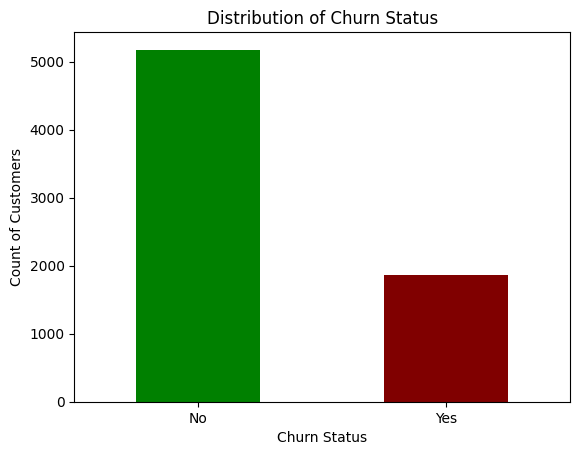

In [22]:
# Check the distribution of the target variable, "Churn Label". 
print(df["Churn Label"].unique())
print(df["Churn Label"].count())
colors_TV = ["green", "maroon"]
df["Churn Label"].value_counts().plot(kind = "bar", xlabel = "Churn Status", ylabel = "Count of Customers", rot = 0, color = colors_TV, 
                                      title = "Distribution of Churn Status")
plt.show()

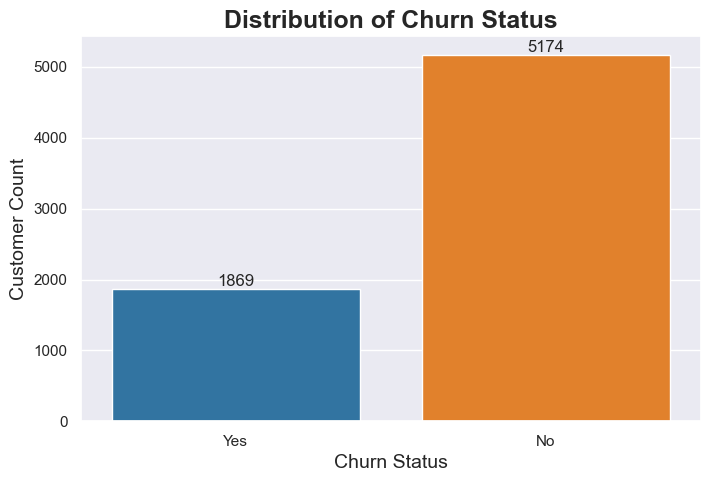

In [23]:
# Alternative bar chart using seaborn
sns.set(style="darkgrid")
countplot, ax = plt.subplots(figsize = (8,5))
ax = sns.countplot(x = df["Churn Label"], data = df, palette = "tab10")
ax.set_title("Distribution of Churn Status",fontsize = 18, fontweight='bold' )
ax.set_xlabel("Churn Status", fontsize = 14)
ax.set_ylabel("Customer Count", fontsize = 14)
for label in ax.containers:
    ax.bar_label(label)

plt.show()

#### We see a misbalanced distribution: more customers stay with the company that churn. 

### Feature Engineering 

In [24]:
# Remove the columns not needed for the analysis: a) those that define the target variable, "churn"; 
# and b) those with no predictive capacity. 
df.drop(["Churn Label", "Churn Score", "CLTV", "Churn Reason"], axis = 1, inplace = True)
df.columns

Index(['CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code',
       'Lat Long', 'Latitude', 'Longitude', 'Gender', 'Senior Citizen',
       'Partner', 'Dependents', 'Tenure Months', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method',
       'Monthly Charges', 'Total Charges', 'Churn Value'],
      dtype='object')

In [25]:
df.drop(["CustomerID", "Count", "Country", "State", "Lat Long"], axis = 1, inplace = True)
df.columns

Index(['City', 'Zip Code', 'Latitude', 'Longitude', 'Gender', 'Senior Citizen',
       'Partner', 'Dependents', 'Tenure Months', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method',
       'Monthly Charges', 'Total Charges', 'Churn Value'],
      dtype='object')

#### No white spaces are accepted in drawing the classifier tree, therefore white spaces in variable "City Names" and columns headings will be removed. 

In [26]:
# Check the city variable. 
df["City"].unique()

array(['Los Angeles', 'Beverly Hills', 'Huntington Park', ..., 'Standish',
       'Tulelake', 'Olympic Valley'], dtype=object)

In [27]:
df["City"].replace(" ", "_", regex = True, inplace = True)
df["City"].unique()[0:10]

array(['Los_Angeles', 'Beverly_Hills', 'Huntington_Park', 'Lynwood',
       'Marina_Del_Rey', 'Inglewood', 'Santa_Monica', 'Torrance',
       'Whittier', 'La_Habra'], dtype=object)

In [28]:
# Remove white space from column headers
df.columns = df.columns.str.replace(" ", "_")
df.columns

Index(['City', 'Zip_Code', 'Latitude', 'Longitude', 'Gender', 'Senior_Citizen',
       'Partner', 'Dependents', 'Tenure_Months', 'Phone_Service',
       'Multiple_Lines', 'Internet_Service', 'Online_Security',
       'Online_Backup', 'Device_Protection', 'Tech_Support', 'Streaming_TV',
       'Streaming_Movies', 'Contract', 'Paperless_Billing', 'Payment_Method',
       'Monthly_Charges', 'Total_Charges', 'Churn_Value'],
      dtype='object')

In [29]:
# Replace blanks with "_" across the entire dataframe. 
df.replace(" ", "_", regex = True, inplace = True)
# df.head(25)

In [30]:
# Double-check the data set's size. 
df.size

169032

In [31]:
# It is recommeded to do the split between independent/feature and dependent/target variables before feature engineering 
# as the latter becomes more straighforward following the separation and no data will be lost even if rows are removed. 
# X will conventionally represent predictors/features while y the label to predict, Churn Value. The default 75/25 split is used.  

X = df.drop(["Churn_Value"], axis = 1).copy() # use copy() to decouple the feature set from the parent data set. 
X.head()

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,Multiple_Lines,Internet_Service,Online_Security,Online_Backup,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,Fiber_optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,Fiber_optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic_check,99.65,820.50
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,Yes,Fiber_optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic_check,104.80,3046.05
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,Yes,Fiber_optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank_transfer_(automatic),103.70,5036.30


In [32]:
y = df["Churn_Value"].copy()
y.head()

0    1
1    1
2    1
3    1
4    1
Name: Churn_Value, dtype: int64

#### Feature Processing: One-Hot Encoding

In [33]:
# Recall the data types.
X.dtypes

City                  object
Zip_Code               int64
Latitude             float64
Longitude            float64
Gender                object
Senior_Citizen        object
Partner               object
Dependents            object
Tenure_Months          int64
Phone_Service         object
Multiple_Lines        object
Internet_Service      object
Online_Security       object
Online_Backup         object
Device_Protection     object
Tech_Support          object
Streaming_TV          object
Streaming_Movies      object
Contract              object
Paperless_Billing     object
Payment_Method        object
Monthly_Charges      float64
Total_Charges        float64
dtype: object

#### The data types look correct for their corresponding values. 

In [34]:
# For one-hot encoding, the get_dummies() function from pandas will be used.
# Test for one feature. 
print(df["Payment_Method"].unique())
pd.get_dummies(X, columns = ["Payment_Method"], dtype = "int64").head()

['Mailed_check' 'Electronic_check' 'Bank_transfer_(automatic)'
 'Credit_card_(automatic)']


,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,Multiple_Lines,Internet_Service,Online_Security,Online_Backup,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Monthly_Charges,Total_Charges,Payment_Method_Bank_transfer_(automatic),Payment_Method_Credit_card_(automatic),Payment_Method_Electronic_check,Payment_Method_Mailed_check
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,53.85,108.15,0,0,0,1
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,Fiber_optic,No,No,No,No,No,No,Month-to-month,Yes,70.70,151.65,0,0,1,0
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,Fiber_optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,99.65,820.50,0,0,1,0
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,Yes,Fiber_optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,104.80,3046.05,0,0,1,0
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,Yes,Fiber_optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,103.70,5036.30,1,0,0,0


In [35]:
# print(X.columns)
X_encoded = pd.get_dummies(X, columns = ['City', 
                                         'Gender', 
                                         'Senior_Citizen',
                                         'Partner', 
                                         'Dependents', 
                                         'Phone_Service',
                                         'Multiple_Lines', 
                                         'Internet_Service', 
                                         'Online_Security',
                                         'Online_Backup', 
                                         'Device_Protection', 
                                         'Tech_Support', 
                                         'Streaming_TV',
                                         'Streaming_Movies',
                                         'Contract', 
                                         'Paperless_Billing', 
                                         'Payment_Method'], dtype = int)
X_encoded.head()

,Zip_Code,Latitude,Longitude,Tenure_Months,Monthly_Charges,Total_Charges,City_Acampo,City_Acton,City_Adelanto,City_Adin,City_Agoura_Hills,City_Aguanga,City_Ahwahnee,City_Alameda,City_Alamo,City_Albany,City_Albion,City_Alderpoint,City_Alhambra,City_Aliso_Viejo,City_Alleghany,City_Alpaugh,City_Alpine,City_Alta,City_Altadena,...,Online_Security_Yes,Online_Backup_No,Online_Backup_No_internet_service,Online_Backup_Yes,Device_Protection_No,Device_Protection_No_internet_service,Device_Protection_Yes,Tech_Support_No,Tech_Support_No_internet_service,Tech_Support_Yes,Streaming_TV_No,Streaming_TV_No_internet_service,Streaming_TV_Yes,Streaming_Movies_No,Streaming_Movies_No_internet_service,Streaming_Movies_Yes,Contract_Month-to-month,Contract_One_year,Contract_Two_year,Paperless_Billing_No,Paperless_Billing_Yes,Payment_Method_Bank_transfer_(automatic),Payment_Method_Credit_card_(automatic),Payment_Method_Electronic_check,Payment_Method_Mailed_check
0,90003,33.964131,-118.272783,2,53.85,108.15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1
1,90005,34.059281,-118.307420,2,70.70,151.65,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0
2,90006,34.048013,-118.293953,8,99.65,820.50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,1,0
3,90010,34.062125,-118.315709,28,104.80,3046.05,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,1,0
4,90015,34.039224,-118.266293,49,103.70,5036.30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,1,1,0,0,0


In [36]:
# Check the values of the target variable to confirm binary distribution, 1 and 0. 
y.unique()

array([1, 0])

### Build the first XGBoost model and assess its performance .

In [37]:
# The first step is to split the data set into training and test subsets. 
# As it has been observed, there is a misbalance of classed in the target variable. 
# More specifically, only about 27% of customers have churned. 
percent_churned = (1869*100)/7043
percent_churned

26.536987079369588

In [38]:
# To overcome the misbalance and avoid underrepresentation of churned customers, stratification sampling technique will be used. 
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state = 42, stratify = y)
print(len(X_train))
print(len(X_test))
churned_y_train = sum(y_train)/len(y_train)
churned_y_train
churned_y_test = sum(y_test)/len(y_test)
churned_y_test

5282
1761


0.26519023282226006

In [39]:
# Create a variable to store trees. The preliminary model trains on the training set; test data are used to evaluating
# the number of trees. The early stopping parameter will be used to control overfitting. 
prelim_xgb = xgb.XGBClassifier(objective = "binary:logistic", seed = 42, eval_metric = "aucpr", early_stopping_roundes = 10)

# Fit the model. 
prelim_xgb.fit(X_train, y_train, verbose = True, eval_set = [(X_test, y_test)])

[0]	validation_0-aucpr:0.64135
[1]	validation_0-aucpr:0.65171
[2]	validation_0-aucpr:0.65991
[3]	validation_0-aucpr:0.65350
[4]	validation_0-aucpr:0.65743
[5]	validation_0-aucpr:0.65051
[6]	validation_0-aucpr:0.65827
[7]	validation_0-aucpr:0.65980
[8]	validation_0-aucpr:0.65751
[9]	validation_0-aucpr:0.65389
[10]	validation_0-aucpr:0.65572
[11]	validation_0-aucpr:0.65920
[12]	validation_0-aucpr:0.66010
[13]	validation_0-aucpr:0.65963
[14]	validation_0-aucpr:0.65877
[15]	validation_0-aucpr:0.65791
[16]	validation_0-aucpr:0.65808
[17]	validation_0-aucpr:0.65742
[18]	validation_0-aucpr:0.65770
[19]	validation_0-aucpr:0.65698
[20]	validation_0-aucpr:0.65733
[21]	validation_0-aucpr:0.65646
[22]	validation_0-aucpr:0.65650
[23]	validation_0-aucpr:0.65270
[24]	validation_0-aucpr:0.65346
[25]	validation_0-aucpr:0.65371
[26]	validation_0-aucpr:0.65406
[27]	validation_0-aucpr:0.65384
[28]	validation_0-aucpr:0.65367
[29]	validation_0-aucpr:0.65419
[30]	validation_0-aucpr:0.65305
[31]	validation_0-

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_roundes=10,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='aucpr', feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

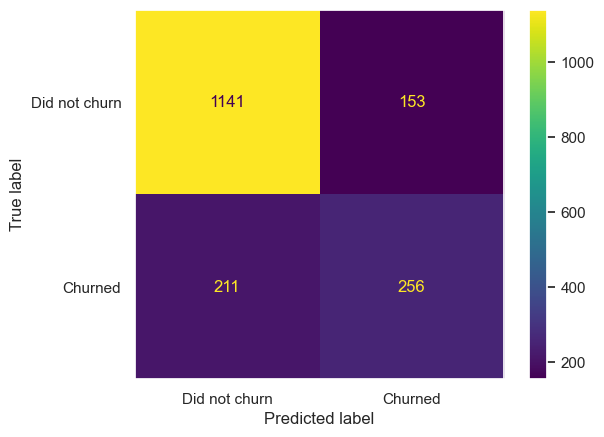

In [40]:
# Now use the model to classify the test data and report performance in a Confusion Matrix. 
ConfusionMatrixDisplay.from_estimator(prelim_xgb, X_test, y_test, 
                                      values_format = "d", display_labels = ["Did not churn", "Churned"])
plt.grid(False)
plt.show()

#### There are 1,761 records in the test set: 1,294 who did not churn and 467 who churned. 
#### Thus, among those who did not leave the company, 88% (1,141) were classified correctly. This leaves as much as 12% (153) as False Positives. 
#### And, among those who did leave, 55% (256) were classified correctly, with as much as 211 or 45% representing False Negatives. 
#### It is clear that the imbalance of the two classes persists and skews results. Considering the goal of the task - to predict 
#### customers likely to leave the company - focus should be placed on reducing the number of False Negatives, i.e., customers predicted 
#### not to churn but who, in reality, did cancel their services. 

### Improve the initial model with hyperparameter tuning and re-assess performance. 

#### The model improvement can include:
#### 1. Performing a GridSearchCV by setting select hyperparamers to initial values and adjusting as needed. 
#### 2. Managing the class imbalance by tuning the hyperparamer "scale_pos_weight" which is recommended for this purpose. The AUC is used for evaluating performance of models. 

In [41]:
# For the "scale_pos_weight" parameter, the recommendation is to use sum(negative records) / sum(positive records) which is ~3 for this data set. 
# Define options for grid grid search, Round 1. 
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.05],
    'gamma': [0, 0.25, 1.0],
    'reg_lambda': [0, 1.0, 10.0],
    'scale_pos_weight': [1, 3, 5] # NOTE: XGBoost recommends sum(negative instances) / sum(positive instances)
}

In [42]:
# For considerations to computational efficiency and prevent overfitting, 90% of randomly sampled data and
# 50% of randomly selected feature subset per tree will be used for the Grid Search with Cross Validation. 
optimal_params = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic', 
                                eval_metric="logloss", ## this avoids a warning...
                                seed=42,
                                subsample=0.9, # Using random 90% of data from the test set per tree. 
                                colsample_bytree=0.5), # Using 50% randomly of columns in the test set per tree. 
    param_grid=param_grid,
    scoring='roc_auc', ## see https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    verbose=0, # NOTE: If you want to see what Grid Search is doing, set verbose=2
    n_jobs = 10,
    cv = 3
)

In [43]:
optimal_params.estimator.set_params(**{"eval_metric":"auc", "early_stopping_rounds":10})

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [44]:
# optimal_params.fit(X_train, 
#                    y_train, 
#                    # early_stopping_rounds=10,                
#                    # eval_metric='auc',
#                    eval_set=[(X_test, y_test)],
#                    verbose=False)

In [46]:
# print(optimal_params1.best_params_)

In [48]:
# optimal_params2 = GridSearchCV(
#     estimator = xgb.XGBClassifier(objective = "binary:logistic",
#                                   eval_metric = "logloss",
#                                   seed = 42, 
#                                   subsample = 0.9,
#                                   colsamples_bytree = 0.5),
#                                   param_grid = params_grid2, 
#                                   scoring = "roc_auc", 
#                                   verbose = 0,
#                                   n_jobs = 10,
#                                   refit = True,
#                                   cv = 3
# )


In [49]:
# optimal_params2.estimator.set_params(**{"eval_metric":"auc", "early_stopping_rounds":10})
# optimal_params2.best_params_

#### The results of the Grid Search yield the following optimal parameters: 
#### gamma = 0.25, learn_rate = 0.1, max_depth = 4, and reg_lambda = 10

In [50]:
# No default pararameters, use those that have been finetuned in the previous section. 
final_xgb = xgb.XGBClassifier(seed=42,
                            missing=0,
                            objective='binary:logistic',
                            gamma=0.25,
                            learning_rate=0.1,
                            max_depth=4,
                            reg_lambda=10,
                            scale_pos_weight=3,
                            subsample=0.9,
                            colsample_bytree=0.5,
                            early_stopping_rounds=10,
                            eval_metric='aucpr')
final_xgb.fit(X_train, 
            y_train, 
            verbose=True, 
            eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.54553
[1]	validation_0-aucpr:0.56880
[2]	validation_0-aucpr:0.62240
[3]	validation_0-aucpr:0.62873
[4]	validation_0-aucpr:0.63428
[5]	validation_0-aucpr:0.63604
[6]	validation_0-aucpr:0.63522
[7]	validation_0-aucpr:0.63455
[8]	validation_0-aucpr:0.63655
[9]	validation_0-aucpr:0.63754
[10]	validation_0-aucpr:0.63783
[11]	validation_0-aucpr:0.63788
[12]	validation_0-aucpr:0.65321
[13]	validation_0-aucpr:0.65616
[14]	validation_0-aucpr:0.66170
[15]	validation_0-aucpr:0.65851
[16]	validation_0-aucpr:0.65455
[17]	validation_0-aucpr:0.65408
[18]	validation_0-aucpr:0.65204
[19]	validation_0-aucpr:0.65714
[20]	validation_0-aucpr:0.65867
[21]	validation_0-aucpr:0.66223
[22]	validation_0-aucpr:0.66289
[23]	validation_0-aucpr:0.66104
[24]	validation_0-aucpr:0.65961
[25]	validation_0-aucpr:0.66056
[26]	validation_0-aucpr:0.65831
[27]	validation_0-aucpr:0.65818
[28]	validation_0-aucpr:0.65987
[29]	validation_0-aucpr:0.65971
[30]	validation_0-aucpr:0.66206
[31]	validation_0-

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=0.25, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=0, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

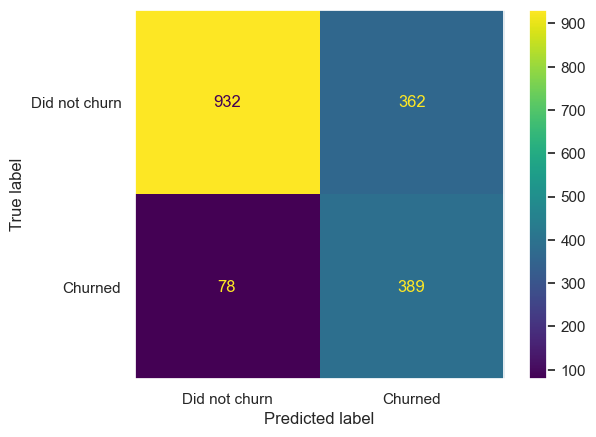

In [51]:
ConfusionMatrixDisplay.from_estimator(final_xgb,
                                      X_test,
                                      y_test,
                                      values_format='d',
                                      display_labels=["Did not churn", "Churned"])
plt.grid(False)
plt.show()

## ANOTHER APPROACH

In [52]:
# Using the same train/test split.

### Build a training pipeline.

In [53]:
# pip install category_encoders

In [54]:
# pip install scikit-optimize

In [55]:
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [56]:
estimators = [
    #("encoder", TargetEncoder()), # encodes into numeric. Not needed. 
    ("clf", XGBClassifier(random_seed = 42))
]
pipe = Pipeline(steps = estimators)
pipe

Pipeline(steps=[('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_seed=42, ...))])

#### Perform hyperparamer tuning and Bayes Optimization Search

In [57]:
# Call nested paramaters within the pipleline as a dictionary. 
search_space = {
    'clf__max_depth': Integer(2,8),
    'clf__learning_rate': Real(0.001, 1.0, prior='log-uniform'),
    'clf__subsample': Real(0.5, 1.0),
    'clf__colsample_bytree': Real(0.5, 1.0),
    'clf__colsample_bylevel': Real(0.5, 1.0),
    'clf__colsample_bynode' : Real(0.5, 1.0),
    'clf__reg_alpha': Real(0.0, 10.0),
    'clf__reg_lambda': Real(0.0, 10.0),
    'clf__gamma': Real(0.0, 10.0)
}

In [58]:
# Variable for the search. 
opt = BayesSearchCV(pipe, search_space, cv=3, n_iter=10, scoring='roc_auc', random_state=8) 
# in reality, you may consider setting cv and n_iter to higher value

In [59]:
# Train the model. 
# opt.fit(X_train, y_train)